In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
%matplotlib inline

/home/marcello/anaconda3/lib/python3.9/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [33]:

# Weights, speed and index of 0 speed in D2Q9
Weights_D2Q9 = np.array( [   1/36,  1/9, 1/36,    1/9,  4/9,  1/9,    1/36,   1/9 ,1/36], float )
########################### 
Ev_name_D2Q9 = {           '-+':0,'0+':1,'++':2,  '-0':3,'00':4,'+0':5,   '--':6,'0-':7,'+-':8 }
VelVecs_D2Q9 = np.array( [ [-1,1],[0,1],[1,1],     [-1,0],[0,0],[1,0],    [-1,-1],[0,-1],[1,-1] ], int )
restIdx_D2Q9 = np.where( np.sum(VelVecs_D2Q9**2,axis=1) == 0 )[0][0]
print('r',restIdx_D2Q9)

Weights = {'D2Q9':Weights_D2Q9}
VelVecs = {'D2Q9':VelVecs_D2Q9}
restIdx = {'D2Q9':restIdx_D2Q9}


#The speed of sound, specifically 1/sqrt(3) ~ 0.57
SpeedOfSound = 1./math.sqrt(3.)
inv_c2  = 1.0 / SpeedOfSound**2
inv_2c4 = 1.0 / ( 2 * SpeedOfSound**4 )
inv_2c2 = 1.0 / ( 2 * SpeedOfSound**2 )
#time relaxation constant
TimeRelaxationConstant = .56
inv_TimeRelaxationConstant = 1.0 / TimeRelaxationConstant
comp_inv_TimeRelaxationConstant = 1.0 - inv_TimeRelaxationConstant

class LBM():
    def __init__(self,res,kind):
        
        self.Weights = Weights[kind]
        self.VelVecs = VelVecs[kind]
        self.restIdx = restIdx[kind]
        self.NQ = len(self.Weights)
        
        self.f = np.zeros((res,res,self.NQ), dtype=float)
        self.f_tmp = np.zeros((res,res,self.NQ), dtype=float)
        self.f_equ = np.zeros((res,res,self.NQ), dtype=float)
        self.eu = np.zeros((res,res,self.NQ), dtype=float)
        self.taylor = np.zeros((res,res,self.NQ), dtype=float)
        self.V = np.zeros((res,res,2),float)
        self.V2 = np.zeros((res,res),float)
        self.D = np.zeros((res,res),float)
        self.T = np.zeros((res,res,self.NQ,3), int)
        self.R = np.zeros((res,res,self.NQ,3), int)
        # start at rest with a unit density
        self.f[:,:,:] = self.Weights
        self.D[:,:] = 1.0
        self.res = res
        self.q = False
        
#        for x in range(6*res//16,8*res//16):
        
        
        for y in range(0,res):
            for x in range(0,res):
                for v in range(self.NQ):
                    # Target, the unique yxf cell this cell is uniquely targeting
                    TargetY = y + self.VelVecs[v][1]
                    TargetX = x + self.VelVecs[v][0]

                    # Periodic Boundary
                    if TargetY == res:
                        TargetY -= res
                    elif TargetY == -1:                       
                        TargetY += res
                        
                    if TargetX == res:
                        TargetX -= res
                    elif TargetX == -1:                       
                        TargetX += res
                    
                    self.T[y,x,v] = (TargetY,TargetX,v)
                    self.R[TargetY,TargetX,v] = (y,x,v)

    def bound(self):
        
        # jet in the center moving to +x
        for y in range(1*res//16,15*res//16):
            for x in range(0*res//16,1*res//16):
                # double the +x population 
                self.f[y,x,5]  = 2 * self.Weights[5]
#                self.f[y,x,:] /= np.sum(self.f[y,x])
                
        # no movement at the boundaries
        self.f[0    ,:,:] = self.Weights
        self.f[res-1,:,:] = self.Weights
        self.f[:,0    ,:] = self.Weights
        self.f[:,res-1,:] = self.Weights

        # obstacle
        for x in range(6*res//16,8*res//16):
            for y in range(4*res//16,6*res//16):
                self.f[y,x,:] = self.Weights
        
    def step( self ):
        self.relax()
        self.advect()
        self.bound()
        self.updateDV()
        
    def relax(self):
        # (internal) Collision
        # self.eu = np.einsum('yxc,ec->yxe', self.V, self.VelVecs)
        self.eu = (self.V.reshape(self.res**2,2) @ self.VelVecs.T).reshape(self.res,self.res,self.NQ)
        self.taylor = 1.0 + self.eu * inv_c2 + self.eu**2 * inv_2c4
        # self.taylor -= np.einsum('yxc,yxc->yx', self.V,self.V)[:,:,None] * inv_2c2        
        self.V2 = self.V[:,:,0]**2 + self.V[:,:,1]**2
        self.taylor -= self.V2[:,:,None] * inv_2c2        
        self.f_equ = self.D[:,:,None] * self.taylor * self.Weights
        self.f_tmp = self.f * comp_inv_TimeRelaxationConstant + self.f_equ * inv_TimeRelaxationConstant

    def advect(self):
        # Streaming
        self.f[ self.T[:,:,:,0], self.T[:,:,:,1], self.T[:,:,:,2] ] = self.f_tmp # direct advection
#        self.f = self.f_tmp[ self.R[:,:,:,0], self.R[:,:,:,1], self.R[:,:,:,2] ]  # or reverse

    def updateDV(self):
        # Update macroscopic variables with new f
        self.D = np.sum(self.f,axis=2)
        #self.V = np.einsum('ic,yxi->yxc', self.VelVecs, self.f) / self.D[:,:,None]
        self.V = (self.f.reshape(self.res**2,self.NQ) @ self.VelVecs ).reshape(res,res,2) / self.D[:,:,None]

    #Momentum of the field
    def Momentum(self):
        return self.V * self.D[:,:,None]
    
    def Pressure(self):
        return self.D
    
    def show(self,ax,fig,display):
        if self.q and ax and ax.images and ax.images[0]:
            ax.images[0].autoscale()
            ax.images[0].set_data(self.Pressure())
        else:
            self.q = True
            ax.imshow(self.Pressure(),vmax=2,vmin=0)
        display.update(fig)
        
Ev_name_D2Q9['--']

r 4


6

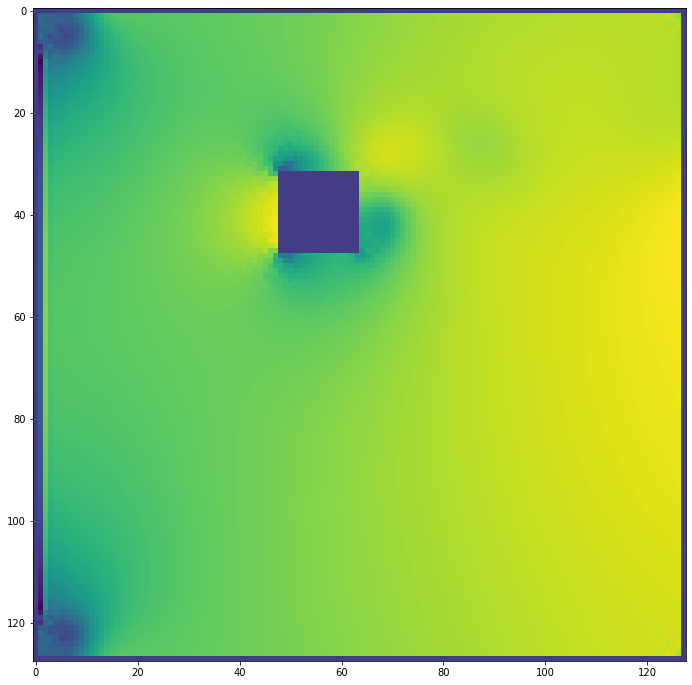

0 16471.11111111111 0.02371689778037581 [8.71111111e+01 6.47953913e-14]
100 18384.922530668853 0.11987756750246137 [1480.13687947    7.53596621]
200 19123.02769400752 0.04567124021933652 [2432.95713502  -55.94875064]
300 19033.558679797046 0.052319570963231164 [2432.53687782  -62.7117477 ]
400 19053.739331522804 0.052776291577150844 [2384.08391738  -40.37920766]
500 19073.102696908725 0.048446412756027735 [2348.53501185  -46.58285884]
600 19075.914506066936 0.048765948174259666 [2357.35339358  -37.88352288]
700 19077.212592275522 0.04907023166109003 [2362.81783252  -27.8204543 ]
800 19079.20432594596 0.04931303742746538 [2365.35574059  -23.20216239]
900 19077.520491677617 0.04916273102575463 [2365.23432176  -29.44248699]
1000 19073.05636677407 0.048818535434848376 [2361.89859579  -42.20093505]
1100 19067.578065486297 0.048383494499000035 [2354.25361706  -55.62463479]
1200 19063.07231542847 0.04801123665603622 [2346.50142449  -65.55604141]


In [40]:
#Resolution of the simulation
res = 128
a = LBM(res,'D2Q9')
#Set initial condition

fig,ax = plt.subplots(1,1, figsize=(12, 12))
hdisplay = display.display("", display_id=True)

#a.D[ 40:60, 40 ] = 1.2
#a.D[ 60, 50 ] = 2

itr = 0
while True:
    try:
        a.step()
#        a.f[30,40,1] = 1.2

    except KeyboardInterrupt:
        break
    
    if itr % 100 == 0:
        print(itr, np.sum(a.D), np.std(a.D.flatten()), np.sum(a.Momentum(),axis=(0,1)))
        a.show(ax,fig,hdisplay)
    itr += 1
    
plt.close(fig)

In [15]:
%timeit a.step()
%timeit a.relax()
%timeit a.advect()
%timeit a.updateDV()

1.18 ms ± 33.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
206 µs ± 2.01 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
143 µs ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
106 µs ± 2.09 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


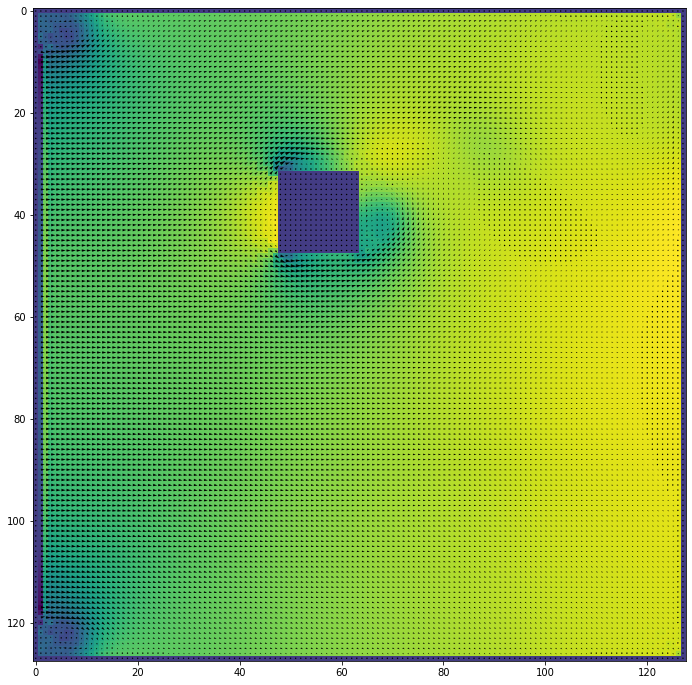

In [47]:
fig,ax = plt.subplots(1,1, figsize=(12, 12))
nf = 1
plt.imshow( a.Pressure()[::nf,::nf] )
plt.quiver( a.V[::nf,::nf,0], -a.V[::nf,::nf,1] )

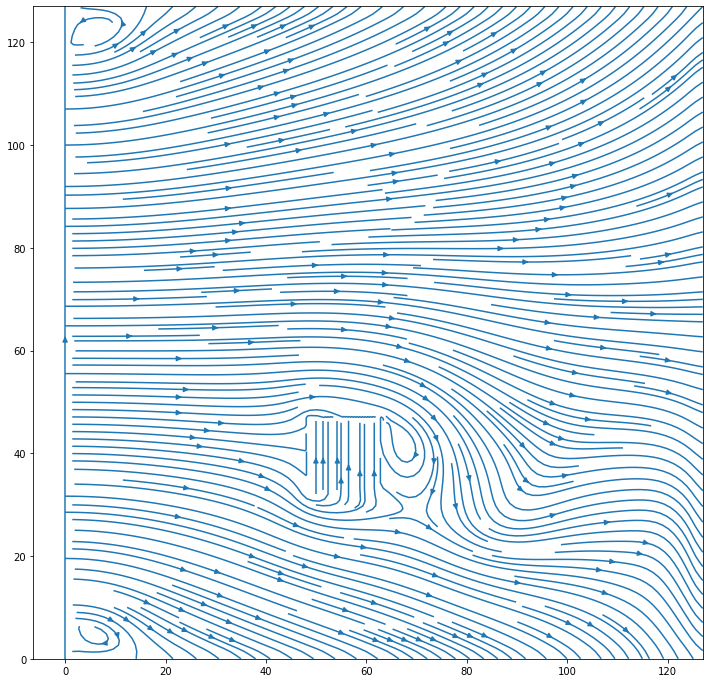

In [46]:
x = y = np.arange(res)
u,v = a.V[:,:,0], a.V[:,:,1]

fig,ax = plt.subplots(1,1, figsize=(12, 12))
plt.streamplot(x,y,u,v,density=(3))

In [ ]:
a.V[50,40]